# Amazon SageMaker Linear Learner algorithm

#### Predicting fashion type using Zalando's Fasion-MNIST dataset (https://github.com/zalandoresearch/fashion-mnist), Amazon SageMaker Linear Learner algorithm for classification and Amazon SageMaker Automatic Model Tuning

Copyright [2018]-[2018] Amazon.com, Inc. or its affiliates. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"). You may not use this file except in compliance with the License. A copy of the License is located at - 

http://aws.amazon.com/apache2.0/

or in the "license" file accompanying this file. This file is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. 

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
  5. [Upload training data](#Upload-training-data)
3. [Training the linear model](#Training-the-linear-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Test the model and see how it performs](#Test-the-model-and-see-how-it-performs)
6. [Improving the model using Hyperparameter tuning](#Improving-the-model-using-hyperparameter-tuning)
7. [A-B testing models using product variants in endpoints](#A-B-testing-models-using-product-variants-in-endpoints)
8. [Cleanup](#Cleanup)

## Introduction

Welcome to our example introducing Amazon SageMaker! To drive this example, we will show you how to use Amazon SageMaker to learn how to build and deploy a model to recognize the type of apparel from images.

The first step in machine learning is to get data to learn from. For our example, we will use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which consists of images of apparel, classified from zero to nine representing what kind of apparel they represent.

This dataset contains labeled examples ( **`x`**, `y`) where **`x`** is a high dimensional vector and `y` is a numeric label. As the dataset we are using for training contains labels for what the correct answer "should be", this example falls under the category of Supervised Learning. Once the model is deployed, we will be predicting which of 10 possible values (0,1,2 .. 9) the image falls under, the type of machine learning we are doing is Supervised Classification. Lastly, since the predictions can be one of 10 values rather than a yes/no type of response, this example demonstrates Supervised Multiclass Classification.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

We use Amazon Simple Storage Service (Amazon S3) to store the training and model data. The S3 bucket should be within the same region as the Notebook Instance, training, and hosting.

If you haven't create an S3 bucket for the use with SageMaker in your account yet you can create one now. 

In [1]:
import sagemaker
from datetime import datetime

# customize environment name to help you find your training jobs and endpoints in SageMaker console
envname = 'ai-ml-id'

# --- do not change values below ---
sess = sagemaker.Session()
bucket = sess.default_bucket()
timestamp = datetime.utcnow().strftime("%s")
print('timestamp :: {}'.format(timestamp))
basicModelName = 'linear-model-basic-{}-{}'.format(envname, timestamp)
advancedModelName = 'linear-model-adv-{}-{}'.format(envname, timestamp)
basicJobName = 'linear-job-basic-{}-{}'.format(envname, timestamp)[:32]
advancedJobName = 'linear-job-adv-{}-{}'.format(envname, timestamp)[:32]
accelerator_regions = ['eu-west-1', 'us-west-2', 'us-east-1', 'us-east-2', 'ap-northeast-1', 'ap-northeast-2']

# the prefix defines the location of our data for this excercise
prefix = 'sagemaker/{}'.format(envname)
# the IAM role is granting SageMaker access to the required resources for this excercise
from sagemaker import get_execution_role
role = get_execution_role()

timestamp :: 1566213698


### Data ingestion

Next we download the dataset and apply some preprocessing prior to training. In this examples this is done using the Jupyter Notebook. For large datasets this would be done *in situ* by Amazon Glue, Apache Spark in Amazon EMR, etc.

The dataset has been made publicly available by Zalando Research [here](https://github.com/zalandoresearch/fashion-mnist). The block below downloads the dataset and extracts the data according to the instructions provided in the link.

In [2]:
%%time
import zipfile, urllib.request, sys

# Load the dataset
urllib.request.urlretrieve("https://github.com/zalandoresearch/fashion-mnist/archive/master.zip", "fashion-mnist.zip")
zip_ref = zipfile.ZipFile("fashion-mnist.zip", 'r')
zip_ref.extractall()
zip_ref.close()

sys.path.append('./fashion-mnist-master/utils')

import mnist_reader
X_train_val, y_train_val = mnist_reader.load_mnist('fashion-mnist-master/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fashion-mnist-master/data/fashion', kind='t10k')


CPU times: user 598 ms, sys: 158 ms, total: 756 ms
Wall time: 2.51 s


The data is structured into two sets of data: One set with 60k labeled entries and another with 10k labeled entries. We will now split the first set into 50k entries for training & 10k entries for validation. The second data set (also 10k) will be used for testing.

In [3]:
# Split the training set into training and validation sets
X_validation = X_train_val[0:10000]
y_validation = y_train_val[0:10000]
X_train = X_train_val[10000:60000]
y_train = y_train_val[10000:60000]

### Data inspection

Once the dataset is loaded, it is typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook.
Note that upon loading the data, train_set contain the n'th image in test_set[0][n] and the corresponding label (which apparel type it is supposed to be) in test_set[1][n]. 

As an example, let's go ahead and look at the 30th image that is part of the dataset.

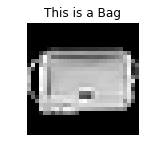

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_item(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)
    

apparel_lookup = {0: 'T-shirt/top',
                  1: 'Trouser',
                  2: 'Pullover',
                  3: 'Dress',
                  4: 'Coat',
                  5: 'Sandal',
                  6: 'Shirt',
                  7: 'Sneaker',
                  8: 'Bag',
                  9: 'Ankle boot'}


show_item(X_train[30], 'This is a {}'.format(apparel_lookup[y_train[30]]))


### Choosing an Algorithm

As we are looking to perform Supervised Multiclass Classification, let's find an appropriate algorithm from among the [Amazon SageMaker built-in algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) makes available to you.

Looking through the list, it looks like the Linear Learner, XGBoost Algorithm or the Image Classification Algorithm would fit  to our needs. 

If you have a highly specialized use case, you can also [bring your own algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms.html)

For this example, we will pick the Linear Learner to get familiar with SageMaker and its capabilities. We encourage you to explore the other algorithms [here (XGBoost for MNIST)](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/xgboost_mnist) and [here (Image Classification Algorithm for Fashion MNIST)](https://aws.amazon.com/blogs/machine-learning/classify-your-own-images-using-amazon-sagemaker/)

### Data conversion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of Linear Learner takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk.

Most of the conversion effort is handled by the Amazon SageMaker Python SDK, imported as `sagemaker` below.

In [5]:
import io
import numpy as np
import sagemaker.amazon.common as smac

# Write the training data
vectors = np.array([t.tolist() for t in X_train]).astype('float32')
labels = np.array([t.tolist() for t in y_train]).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

0

### Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [6]:
import boto3
import os

key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-us-east-1-182181415328/sagemaker/ai-ml-id/train/recordio-pb-data


Now that our inputs are in S3, ready to be used for training, let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [7]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://sagemaker-us-east-1-182181415328/sagemaker/ai-ml-id/output


## Training the linear model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the Linear Learner training algorithm, although we have tested it on multi-terabyte datasets.

Again, we'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed.  In this example that takes between 7 and 11 minutes.  Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

First, let's specify our container.  Since we want this notebook to run in any of the Amazon SageMaker's regions, we'll create a small lookup.  More details on algorithm containers can be found in [AWS documentation](https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html). Note that the lookup also gets to location of the Linear Learner algorithm in the region that the notebook is running in.

In [8]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')
print('using container image: {}'.format(container))

using container image: 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


Using the container we have obtained, we will create a sagemaker estimator object that represents the Linear Learner algorithm

In [9]:
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess,
                                       tags=[ 
                                           {'Key':'model', 'Value':'linear-learner'}, 
                                           {'Key':'version', 'Value':'basic'}, 
                                           {'Key': 'Name', 'Value':basicModelName}
                                       ], 
                                       base_job_name='{}-trainjob'.format(envname))

Before we get to training on the dataset, we have to specify some hyperparameters. Hyperparameters can be seen as information that we provide to the estimator to control the way the estimator treats and learns from the data.

- `feature_dim` is set to 784, which is the number of pixels in each 28 x 28 image.
- `predictor_type` is set to 'multi_classifier' since we are doing a Multiclass Classification
- `num_classes` is set to 10 since we can have 10 different predictions for an image (0,1,2...9)

In [10]:
linear.set_hyperparameters(feature_dim=784,
                           predictor_type='multiclass_classifier',
                           num_classes = 10)

We are now ready to train our model. We can do this simply by calling fit() and specificying our training and validation data. While you wait for the training to finish, take some time to review the [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) to find out what other hypermarameter options are available for the Linear Learner algorithm or to get a feeling of the other algorithms available .

In [11]:
linear.fit(
                {'train': s3_train_data}, 
                job_name=basicJobName
          )
jobStatus = boto3.client('sagemaker').describe_training_job(TrainingJobName=basicJobName)
print(jobStatus)

2019-08-19 11:21:55 Starting - Starting the training job...
2019-08-19 11:21:58 Starting - Launching requested ML instances......
2019-08-19 11:23:01 Starting - Preparing the instances for training......
2019-08-19 11:24:07 Downloading - Downloading input data...
2019-08-19 11:24:47 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[08/19/2019 11:24:50 INFO 140465489983296] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': 

## Set up hosting for the model

Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow us to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, or other deployment target, we will discuss more of those options towards the end of the workshop._

Depending on the region your SageMaker instance is running in, we may add an Elastic Inference accelerator card to the instance.

For currently supported regions, please see https://aws.amazon.com/machine-learning/elastic-inference/pricing/

The Elastic Inference accelerator card can simply be attached by specifying a value for the accelerator_type parameter.


In [28]:
#Set this to true if your account has the proper limit increased and you want to try using elastic inference
use_elastic_inference = False

if sess.boto_region_name in accelerator_regions and use_elastic_inference:

    print('Using an Elastic Inference accelerator because we\'re in the \'{}\ region.'.format(sess.boto_region_name))
    linear_predictor = linear.deploy(initial_instance_count=1,
                                     instance_type='ml.m5.2xlarge', 
                                     accelerator_type='ml.eia1.medium',
                                     endpoint_name='{}-endpoint'.format(envname))
else:

    print('Skipping use of Elastic Inference.'.format(sess.boto_region_name))
    linear_predictor = linear.deploy(initial_instance_count=1,
                                     instance_type='ml.m5.2xlarge',
                                     accelerator_type=None,
                                     endpoint_name='{}-endpoint'.format(envname))


Skipping use of Elastic Inference.


Using already existing model: linear-job-basic-ai-ml-id-156621


--------------------------------------------------------------------------------------------------!


If our example would require a GPU to serve predictions, with Elastic Inference we can use a small ml.m5 family machine, rather than an ml.p3, and offload the processing to the Elastic Inference addon card.

To compare costs, 

an ml.eial.medium costs `$ 0.140/hour` in us-west-1, and an ml.m5.2xlarge, which is `$ 0.538 / hour`, 
giving us an hourly run rate of `$ 0.678` for this configuration.

Whereas, if we just specified bigger machines we would be looking at something like

ml.p3.2xlarge, which is $ `4.284/hour` in us-west-1

giving an hourly saving of around **87%**!!

For more details on pricing, please see https://aws.amazon.com/machine-learning/elastic-inference/pricing/



## Test the model and see how it performs
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

In [29]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

Now let's try getting a prediction for a single record. We will display the image and the prediction

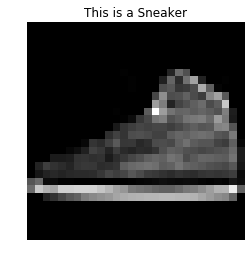

In [30]:
ind = 45
result = linear_predictor.predict(X_test[ind:ind+1])
show_item(X_test[ind:ind+1], 'This is a {}'.format(apparel_lookup[int(float(result['predictions'][0]['predicted_label']))]))

OK, a single prediction seems to work.  We see that for one record our endpoint returned some JSON which contains `predictions`, including the `score` and `predicted_label`.  In this case, `score` will be a continuous value between [0, 1] representing the probability we think that the image corresponds to each possible prediction (0,1,2,.9).  `predicted_label` will be a value from (0,1,2,3...9) which indicates what number the model thinks the image contains

Let's do a whole batch of images and evaluate our predictive accuracy.

In [31]:
import numpy as np

predictions = []
for array in np.array_split(X_test, 100):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]


predictions = np.array(predictions)

Now we that we have our predictions from the test set, let us build a confusion matrix. The confusion matrix shows us the count of the actual labels (along the rows) versus the predicted labels (along the columns). 

In [32]:
import pandas as pd
actual_labels = np.array(y_test)
pd.crosstab(actual_labels, predictions, rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
actuals,,,,,,,,,,
0,838,1,15,49,5,2,77,1,11,1
1,3,955,5,26,6,0,3,0,2,0
2,19,4,706,12,159,2,94,1,3,0
3,33,13,11,870,40,2,26,0,5,0
4,0,1,79,36,797,2,75,1,9,0
5,0,1,0,0,0,905,0,49,5,40
6,183,4,118,39,116,2,525,0,13,0
7,0,0,0,0,0,32,0,883,1,84
8,2,1,7,12,3,5,30,4,932,4


Since this matrix is dominant along the diagonal, it looks like the algorithm did pretty well! Let us check how often we got it right

In [33]:
correct_preds = 0
for i in range(1,len(actual_labels)):
    if actual_labels[i] == predictions[i]:
        correct_preds = correct_preds + 1

print('The model predicted correctly on {}% of the test set'.format(correct_preds*100/len(actual_labels)))

The model predicted correctly on 83.79% of the test set


For a fun next step, let us try to classify a random piece of apparel that you get off the internet!

This is a T-shirt/top


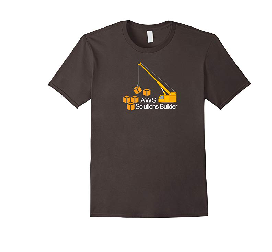

In [34]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

# Change the imgsrc with a link to an image of your choice with a white background
imgsrc = 'https://images-na.ssl-images-amazon.com/images/I/81OaXwn1x4L._UX679_.jpg'
#imgsrc = 'https://images-eu.ssl-images-amazon.com/images/I/31TcgNHsbIL._AC_UL260_SR200,260_.jpg'
#imgsrc = 'https://images-eu.ssl-images-amazon.com/images/I/41hWhZBIc3L._AC_UL260_SR200,260_.jpg'
imglocname = 'localimage.jpg'

#Download the file locally
urllib.request.urlretrieve(imgsrc, imglocname)

# Resize and convert to grayscale
def rgb2gray(rgb):
    return np.dot((255-rgb[...,:3]), [0.299, 0.587, 0.114])

fullimgread = Image.open(imglocname)   
imgread = fullimgread.resize((28, 28))
gray = rgb2gray(np.asarray( imgread, dtype="int32" ))

# Do the prediction!
result = linear_predictor.predict(gray.reshape((1,784)))

print ('This is a {}'.format(apparel_lookup[int(float(result['predictions'][0]['predicted_label']))]))
plt.imshow(fullimgread)
plt.axis('off')
plt.show() 



## Improving the model using hyperparameter tuning

Despite having a good model, let us take a moment to see if we can do better!
We discussed hyperparameters earlier that we used to instruct the algorithm on some characteristics of the data. However, hyperparameters also include some adjustable 'settings' for the algorithm itself. So far, we have used the default values, but picking the right values for some of these hyperparameters can help us improve the model.

Each algorithm has its own hyperparameters. If you have not managed to look them up by yourself earlier, these are the [hyperparameters for the linear learner](https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html)

How can we arrive at the 'best values' for these hyperparameters? Amazon SageMaker provides [Automatic Model Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner-tuning.html) to allow you to use your test and validation datasets to identify the best hyperparameters for your particular use case.

First, let us prepare the validation data in the same way we prepared the training data.


In [35]:
# Prepare the validation data
validation_vectors = np.array([t.tolist() for t in X_validation]).astype('float32')
validation_labels = np.array([t.tolist() for t in y_validation]).astype('float32')

validation_buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(validation_buf, validation_vectors, validation_labels)
validation_buf.seek(0)

key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', key)).upload_fileobj(validation_buf)
s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_validation_data))

uploaded validation data location: s3://sagemaker-us-east-1-182181415328/sagemaker/ai-ml-id/validation/recordio-pb-data


Let us now set up Amazon SageMaker's hyperparameter tuning capabilities. We will use four of the [Linear Learner Tuning Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner-tuning.html) and their recommended ranges. 

Note: These were chosen primarily to demonstrate the different types of hyperparameters you can tune. You might be able to achieve better or faster results by choosing a different set of hyperparameters and ranges.

In [36]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter

hyperparameters_to_tune = { 'wd': ContinuousParameter(0.001, 0.1),
                         'learning_rate': ContinuousParameter(0.001, 0.01),
                        }

We now have to choose a metric for the hyperparameter optimization. For this example, we will use the validation:objective_loss metric. This is also the reason we are including validation data in our model tuning step below.

Let us set up the tuner itself and have it tune the model and hopefully come up with a better model!

In [37]:
from sagemaker.tuner import HyperparameterTuner

linear_tuner = HyperparameterTuner(estimator=linear,
                            objective_metric_name = 'validation:objective_loss',
                            objective_type = 'Minimize',
                            hyperparameter_ranges=hyperparameters_to_tune,
                            max_jobs=10,
                            max_parallel_jobs=2,
                            tags=[ 
                                {'Key':'model', 'Value':'linear-learner'}, 
                                {'Key':'version', 'Value':'hpo'}, 
                                {'Key': 'Name', 'Value':advancedModelName}
                            ], 
                            base_tuning_job_name='{}-hpojob'.format(envname))

linear_tuner.fit(
    inputs={'train': s3_train_data, 'validation': s3_validation_data}, 
    include_cls_metadata=False, 
    job_name=advancedJobName
)

When we call fit() with a HyperparameterTuner object, it initiates a job that will typically run through many iterations. During this process, you can always access the best model the job has found so far. For our example today, we will wait until the job is complete. Run the block below to get the latest status. When the status is 'Completed', we will move to the next block.

In [59]:
from pprint import pprint
import time

sagemaker = boto3.Session().client(service_name='sagemaker') 

tuning_job_result = sagemaker.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=advancedJobName)
status = tuning_job_result['HyperParameterTuningJobStatus']
#print(status)
counter = 0
best_job_yet = None
last_job_count = -1
job_count = 0

while status != 'Completed' and counter < 360:

    job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
    if job_count != last_job_count:
        last_job_count = job_count
        print("\n%d training jobs have completed out of 10" % job_count)
        statstr = 'Status: {}'.format(tuning_job_result['HyperParameterTuningJobStatus'])
        if (tuning_job_result['HyperParameterTuningJobStatus'] != 'Completed'):
            statstr = statstr + '\nRunning Since: ' + str(tuning_job_result['CreationTime'])
            statstr = statstr + '\nTraining Jobs Completed: ' + str(tuning_job_result['TrainingJobStatusCounters']['Completed'])
            statstr = statstr + '\nTraining Jobs In Progress: ' + str(tuning_job_result['TrainingJobStatusCounters']['InProgress'])
            fail_jobs = tuning_job_result['TrainingJobStatusCounters']['RetryableError'] + tuning_job_result['TrainingJobStatusCounters']['NonRetryableError']
            statstr = statstr + '\nTraining Jobs Failed: ' + str(fail_jobs)
            statstr = statstr + '\nMaximum Training Jobs: ' + str(tuning_job_result['HyperParameterTuningJobConfig']['ResourceLimits']['MaxNumberOfTrainingJobs'])
        print(statstr)
        if tuning_job_result.get('BestTrainingJob', None):
            current_job = tuning_job_result['BestTrainingJob']
            if current_job != best_job_yet:
                best_job_yet = current_job
                print('\nNew best model found!')
            
    # sleep for 5 and then update markers
    time.sleep(5)
    print('.', end = '')
    counter += 1
    tuning_job_result = sagemaker.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=advancedJobName)
    status = tuning_job_result['HyperParameterTuningJobStatus']
    if status == 'Failed':
        raise Exception('Job failed because :: {}'.format(tuning_job_result['FailureReason']))

if tuning_job_result.get('BestTrainingJob', None):
    print("\nBest model after training:")
    pprint(tuning_job_result['BestTrainingJob'])



Best model after training:
{'CreationTime': datetime.datetime(2019, 8, 19, 12, 53, 26, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:objective_loss',
                                                 'Value': 0.4290805757045746},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2019, 8, 19, 12, 56, 24, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:182181415328:training-job/linear-job-adv-ai-ml-id-15662136-010-63ee0994',
 'TrainingJobName': 'linear-job-adv-ai-ml-id-15662136-010-63ee0994',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2019, 8, 19, 12, 55, 20, tzinfo=tzlocal()),
 'TunedHyperParameters': {'learning_rate': '0.0023889027734147463',
                          'wd': '0.0032105674974342384'}}


By running a variety of training jobs, the hyperparameter tuner has now identified a set of hyperparameters that give us the best results in terms of the objective metric (in our case, the objective_loss). Let us go ahead and deploy this model in a similar fashion to how we deployed the model earlier.

In [39]:
linear_tuned_predictor = linear_tuner.deploy(initial_instance_count=1,
                                instance_type='ml.m4.xlarge',
                                endpoint_name='{}-tunedendpoint'.
                                format(envname))

2019-08-19 12:56:24 Starting - Preparing the instances for training
2019-08-19 12:56:24 Downloading - Downloading input data
2019-08-19 12:56:24 Training - Training image download completed. Training in progress.
2019-08-19 12:56:24 Uploading - Uploading generated training model
2019-08-19 12:56:24 Completed - Training job completedDocker entrypoint called with argument(s): train
[08/19/2019 12:56:09 INFO 139859248944960] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_r

We will now run the test set against our newly deployed endpoint and gather the predictions

In [40]:
linear_tuned_predictor.content_type = 'text/csv'
linear_tuned_predictor.serializer = csv_serializer
linear_tuned_predictor.deserializer = json_deserializer

predictions = []
for array in np.array_split(X_test, 100):
    result = linear_tuned_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

Now for the moment of truth! 

Let us calculate how often the tuned model got the right prediction and also generate the corresponding confusion matrix.

In [41]:
actual_labels = np.array(y_test)
correct_preds = 0
for i in range(1,len(actual_labels)):
    if actual_labels[i] == predictions[i]:
        correct_preds = correct_preds + 1

print('The tuned model predicted correctly on {}% of the test set'.format(correct_preds*100/len(actual_labels)))

pd.crosstab(actual_labels, predictions, rownames=['actuals'], colnames=['predictions'])

The tuned model predicted correctly on 84.4% of the test set


predictions,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
actuals,,,,,,,,,,
0,824,1,14,50,6,3,88,1,13,0
1,5,953,4,27,6,0,3,0,2,0
2,24,4,734,8,141,2,79,0,8,0
3,25,13,16,873,29,2,35,0,7,0
4,0,1,105,37,759,1,88,0,9,0
5,0,0,0,1,0,932,0,40,4,23
6,147,3,120,39,111,2,557,0,21,0
7,0,0,0,0,0,42,0,919,0,39
8,5,1,7,11,2,6,18,4,944,2


### Review

Let us quickly summarize what we achieved so far. We have taken a common dataset (Fashion MNIST) and used Amazon SageMaker with it's Linear Learner algorithm to train a multiclass classification model that allows us to predict fashion items among 10 different categories. Once trained we deployed the trained model using Amazon SageMaker's model hosting capabilities to create a fully-managed, automated scalable model endpoint. 

Finally we have used the Automatic Model Tuning to help us find the best version of a model by running many training jobs against our dataset using the algorithm and ranges of hyperparameters that we specified. 

### Stage clean up

We can now delete the endpoints that we created in this section.

In [42]:
# delete model endpoint
linear_predictor.delete_endpoint()
linear_tuned_predictor.delete_endpoint()


## A-B testing models using product variants in endpoints

Ok, so we've trained a quick model and a hyperparameter tuned model, deployed and tested them, and now torn down the endpoints.

In a real world situation we would probably want to use an A/B deployment or similar, so let's have a look at that.

Let's start off with defining a few helper functions that return a model ARN from a normal training job or the best model from an HPO job using the SageMaker API.

In [43]:
import json
import matplotlib.pyplot as plt

def createModelFromHpoJob(trainingJobName, modelName):
    
    info = sagemaker.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=trainingJobName)
    resolvedJobName = info['BestTrainingJob']['TrainingJobName']
    print('best training job resolved as : {}'.format(resolvedJobName))
    return createModel(resolvedJobName, modelName)

def createModel (trainingJobName, modelName, hyper = False):
    
    info = sagemaker.describe_training_job(TrainingJobName=trainingJobName)
    container = info['AlgorithmSpecification']['TrainingImage']
    model_data = info['ModelArtifacts']['S3ModelArtifacts']

    #print('trainging info : {}'.format(info))
    print('container : {}'.format(container))
    print('model data : {}'.format(model_data))

    primary_container = {
        'Image': container,
        'ModelDataUrl': model_data
    }

    print('creating model :: {}'.format(modelName))

    create_model_response = sagemaker.create_model(
        ModelName = modelName,
        ExecutionRoleArn = role,
        PrimaryContainer = primary_container)

    return create_model_response['ModelArn']


Let's get a reference to the basic model first...

In [44]:
basicModelArn = createModel(basicJobName, basicModelName)
print('basic model created as : {}'.format(basicModelArn))


container : 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1
model data : s3://sagemaker-us-east-1-182181415328/sagemaker/ai-ml-id/output/linear-job-basic-ai-ml-id-156621/output/model.tar.gz
creating model :: linear-model-basic-ai-ml-id-1566213698
basic model created as : arn:aws:sagemaker:us-east-1:182181415328:model/linear-model-basic-ai-ml-id-1566213698


And the same for the advanced HPO one...

In [45]:
advancedModelArn = createModelFromHpoJob(advancedJobName, advancedModelName)
print('advanced model created as : {}'.format(advancedModelArn))

best training job resolved as : linear-job-adv-ai-ml-id-15662136-010-63ee0994
container : 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1
model data : s3://sagemaker-us-east-1-182181415328/sagemaker/ai-ml-id/output/linear-job-adv-ai-ml-id-15662136-010-63ee0994/output/model.tar.gz
creating model :: linear-model-adv-ai-ml-id-1566213698
advanced model created as : arn:aws:sagemaker:us-east-1:182181415328:model/linear-model-adv-ai-ml-id-1566213698


So we've created models from the best jobs, now we create a config referencing both models. The integer values for 'InitialWeightVariant' are whatever you feel gives you the granualarity to express the distribution you want.

In [46]:
endpointConfigName = 'linear-endpoint-config-{}-{}'.format(envname, timestamp)

create_endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName = endpointConfigName,
    ProductionVariants=[
        {
            'InstanceType':'ml.m4.xlarge',
            'InitialInstanceCount':1,
            'ModelName':basicModelName,
            'InitialVariantWeight':9, 
            'VariantName':'basicTraffic'}, 
        {
            'InstanceType':'ml.m4.xlarge',
            'InitialInstanceCount':1,
            'ModelName':advancedModelName,
            'InitialVariantWeight':1,
            'VariantName':'hpoTraffic'
        }
    ])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])


Endpoint Config Arn: arn:aws:sagemaker:us-east-1:182181415328:endpoint-config/linear-endpoint-config-ai-ml-id-1566213698


Now we can create an endpoint, using this dual model config

In [47]:
%%time

endpointName = 'linear-endpoint-{}-{}'.format(envname, timestamp)

create_endpoint_response = sagemaker.create_endpoint(
    EndpointName=endpointName,
    EndpointConfigName=endpointConfigName)

print('Creating endpoint ARN : {}'.format(create_endpoint_response['EndpointArn']))

resp = sagemaker.describe_endpoint(EndpointName=endpointName)
status = resp['EndpointStatus']
print("Status : " + status)

while status=='Creating':
    time.sleep(10)
    resp = sagemaker.describe_endpoint(EndpointName=endpointName)
    status = resp['EndpointStatus']
    print('.', end = '')

print('\nEndpoint created as : {}'.format(resp['EndpointArn']))
print('Status : {}'.format(status))

Creating endpoint ARN : arn:aws:sagemaker:us-east-1:182181415328:endpoint/linear-endpoint-ai-ml-id-1566213698
Status : Creating
..................................................
Endpoint created as : arn:aws:sagemaker:us-east-1:182181415328:endpoint/linear-endpoint-ai-ml-id-1566213698
Status : InService
CPU times: user 546 ms, sys: 28.7 ms, total: 575 ms
Wall time: 8min 23s


So, at this stage we have an new SageMaker Endpoint, balancing between the two models that we have created so far.

You can see the created endpoint in the console using the following link

https://console.aws.amazon.com/sagemaker/home?#/endpoints

If you click into the new endpoint, and scroll down tp the Product Varinat section, you will see the model names, initial weights, variant names etc for each Product Variant that we have defined.

Now we'll set up our environment to do some requests against this endpoint.

First, we need a SageMaker runtime client

In [48]:
runtime_client = boto3.client('sagemaker-runtime')

Next we need to define some variables and helper functions, to convert gray scale, and to log

In [49]:
imgLocalName = 'test_image.jpg'

def rgb2gray(rgb):
    return np.dot((255-rgb[...,:3]), [0.299, 0.587, 0.114])

def predict(body): 

    response = runtime_client.invoke_endpoint(
        EndpointName=endpointName,
        Body=body,
        ContentType='text/csv',
        Accept='application/json'
    )

    return response

def get_product_variant(response):
    
    return response['ResponseMetadata']['HTTPHeaders']['x-amzn-invoked-production-variant']
    
def resolve_prediction(response):
    
    # print (response)
    # let's look at the body now...
    result = json.loads(response['Body'].read().decode())
    print('----------------------------')
    print ('        prediction')
    print('----------------------------')

    print ('This is a {}'.format(apparel_lookup[int(float(result['predictions'][0]['predicted_label']))]))
    
    return result

def test_variant(max):
    mydict = {'basicTraffic': 0, 'hpoTraffic': 0}

    for x in range(1, max):
        result = predict(body)
        variant = get_product_variant(result)
        if (variant == 'basicTraffic'):
            mydict['basicTraffic'] += 1
        else:
            mydict['hpoTraffic'] += 1

    #print(mydict)
    pd.Series(mydict).plot(kind='barh')


Now we can download an image and read it

In [50]:
#imgSrc = 'https://images-na.ssl-images-amazon.com/images/I/81OaXwn1x4L._UX679_.jpg'
imgSrc = 'https://images-eu.ssl-images-amazon.com/images/I/31TcgNHsbIL._AC_UL260_SR200,260_.jpg'

urllib.request.urlretrieve(imgSrc, imgLocalName)

fullimgread = Image.open(imgLocalName)
imgread = fullimgread.resize((28, 28))
gray = rgb2gray(np.asarray( imgread, dtype="int32" ))
# make it a 1d array
grayShape = gray.reshape((1,784))

# convert to csv for request
body = ''
for x in np.nditer(grayShape):
    body += str((x)) + ','

# strip last comma
body = body[:-1]

And we're ready to make a prediction

----------------------------
        prediction
----------------------------
This is a Sandal


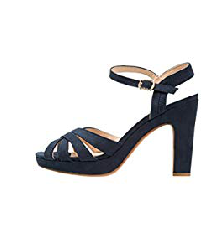

In [51]:
result = predict(body)
resolve_prediction(result)

plt.imshow(fullimgread)
plt.axis('off')
plt.show() 

We currently have a 9 in 10 chance of hitting the basicTraffic model.

Let's test that out, and run a small series of predictions against our current configuration

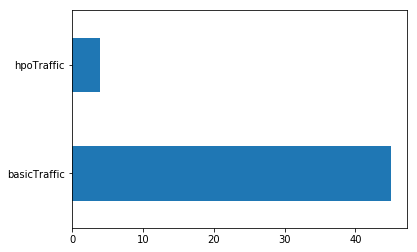

In [52]:
test_variant(50)


These results should look plausible, so now let's update the distribution to 50/50 by setting the DesiredWeights to 5 and 5 and calling the update_endpoint_weights_and_capacities endpoint.


In [53]:
sagemaker.update_endpoint_weights_and_capacities(
    EndpointName=endpointName,
    DesiredWeightsAndCapacities=[
        {
            'VariantName': 'basicTraffic',
            'DesiredWeight': 5
        },
        {
            'VariantName': 'hpoTraffic',
            'DesiredWeight': 5
        }
    ]
)


{'EndpointArn': 'arn:aws:sagemaker:us-east-1:182181415328:endpoint/linear-endpoint-ai-ml-id-1566213698',
 'ResponseMetadata': {'RequestId': '6e9cafad-37da-49ad-8c26-91c9dba6015b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6e9cafad-37da-49ad-8c26-91c9dba6015b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '103',
   'date': 'Mon, 19 Aug 2019 13:12:42 GMT'},
  'RetryAttempts': 0}}

Now hop over to the SageMaker console, and find your endpoint, and wait for it to finish updating.

You can see the endpoint in the console using the following link

https://console.aws.amazon.com/sagemaker/home?#/endpoints



In [54]:
resp = sagemaker.describe_endpoint(EndpointName=endpointName)
status = resp['EndpointStatus']
print("Status : " + status)

while status=='Updating':
    time.sleep(5)
    resp = sagemaker.describe_endpoint(EndpointName=endpointName)
    status = resp['EndpointStatus']
    print('.', end = '')

time.sleep(45)

print("\nStatus : " + status)

Status : Updating
.............
Status : InService


During the updating process traffic will of course be served by the existing config until the new one is scaled up, health checks passed, and it is ready to serve traffic.


When it's finished updating, we will run the same test...

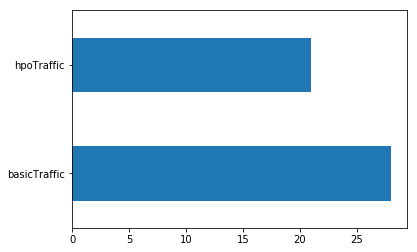

In [55]:
test_variant(50)

Ok, so that hopefully looks pretty even. 
(If it's not quite there yet then run that step again)

Now let's go to 100% hpoTraffic.

In [56]:
sagemaker.update_endpoint_weights_and_capacities(
    EndpointName=endpointName,
    DesiredWeightsAndCapacities=[
        {
            'VariantName': 'basicTraffic',
            'DesiredWeight': 0
        },
        {
            'VariantName': 'hpoTraffic',
            'DesiredWeight': 10
        }
    ]
)
resp = sagemaker.describe_endpoint(EndpointName=endpointName)
status = resp['EndpointStatus']
print("Status : " + status)

while status=='Updating':
    time.sleep(5)
    resp = sagemaker.describe_endpoint(EndpointName=endpointName)
    status = resp['EndpointStatus']
    print('.', end = '')

time.sleep(45)
print("\nStatus : " + status)

Status : Updating
.............
Status : InService


As before, we need to go and look in the SageMaker console to see when it has finished updating, 
and then run the next cell.

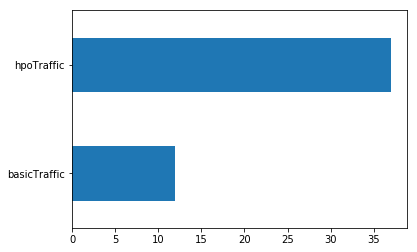

In [57]:
test_variant(50)

And there we have it, 100% cut over to the newer hpo tuned model.
(If it's not quite there yet then run it again)

## Cleanup

Finally, let's clean up local disk space for good hygiene, as well as the Endpoint and the Endpoint Configuration

In [58]:
!rm -rf fashion-mnist.zip
!rm -rf fashion-mnist-master
!rm -rf test_image.jpg
!rm -rf localimage.jpg

sagemaker.delete_endpoint(EndpointName=endpointName)
sagemaker.delete_endpoint_config(EndpointConfigName=endpointConfigName)


{'ResponseMetadata': {'RequestId': '87dda69a-e23e-4e58-9162-6d44999855c2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '87dda69a-e23e-4e58-9162-6d44999855c2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 19 Aug 2019 13:16:29 GMT'},
  'RetryAttempts': 0}}